In [46]:
from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import sys
sys.path.append('../corv/src')
sys.path.append('../wdtools')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
import pandas as pd

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c
#import photoradius as pr

In [47]:
import os

os.system("""
    pwd
""")

/media/arseneau/WD Drive/gravitational-redshift/sdss5


0

In [63]:
sdss5_catalog = Table.read('data/01_in_sdss5.fits')
#print(sdss5_catalog.keys())

In [64]:
print(sdss5_catalog.keys())

['pos_id', 'PROGRAMNAME', 'CHUNK', 'SURVEY', 'PLATEQUALITY', 'PLATESN2', 'DEREDSN2', 'PRIMTARGET', 'SECTARGET', 'LAMBDA_EFF', 'BLUEFIBER', 'ZOFFSET', 'XFOCAL', 'YFOCAL', 'SPECPRIMARY', 'SPECBOSS', 'BOSS_SPECOBJ_ID', 'NSPECOBS', 'CALIBFLUX', 'CALIBFLUX_IVAR', 'GAIA_BP', 'GAIA_RP', 'GAIA_G', 'FIRSTCARTON', 'MAG', 'PLATE', 'DESIGNID', 'NEXP', 'EXPTIME', 'AIRMASS', 'HEALPIX', 'HEALPIXGRP', 'HEALPIX_DIR', 'MJD_FINAL', 'MJD_LIST', 'TAI_LIST', 'PLATESNR2G_LIST', 'PLATESNR2R_LIST', 'PLATESNR2I_LIST', 'MOON_DIST', 'MOON_PHASE', 'SFD_EBV', 'WISE_MAG', 'TWOMASS_MAG', 'GUVCAT_MAG', 'GAIA_PARALLAX', 'GAIA_PMRA', 'GAIA_PMDEC', 'XCSAO_RV', 'XCSAO_ERV', 'XCSAO_RXC', 'XCSAO_TEFF', 'XCSAO_ETEFF', 'XCSAO_LOGG', 'XCSAO_ELOGG', 'XCSAO_FEH', 'XCSAO_EFEH', 'CATALOGID', 'SDSSV_BOSS_TARGET0', 'FIELD', 'TILE', 'MJD', 'FIBERID', 'RUN2D', 'RUN1D', 'OBJTYPE', 'PLUG_RA', 'PLUG_DEC', 'CLASS', 'SUBCLASS', 'Z', 'Z_ERR', 'RCHI2', 'DOF', 'RCHI2DIFF', 'TFILE', 'TCOLUMN', 'NPOLY', 'THETA', 'VDISP', 'VDISP_ERR', 'VDISPZ', 

In [65]:
ADQL_CODE1 = "SELECT \
        sdss.original_ext_source_id as bestobjid,\
        gaia_source.source_id\
        FROM gaiaedr3.gaia_source \
        JOIN gaiaedr3.sdssdr13_best_neighbour as sdss\
        ON gaia_source.source_id = sdss.source_id      \
        WHERE gaia_source.source_id IN {}\
    ".format(tuple(sdss5_catalog['wd_source_id']))

job1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False)
d1 = job1.get_results()

In [66]:
drops = []
bestobjid1 = []

for i in tqdm (range(len(sdss5_catalog))):
    notfound = False
    a = np.where(d1['source_id'] == sdss5_catalog['wd_source_id'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        try:
            bestobjid1.append(d1['bestobjid'][j])
        except:
            notfound = True
    if notfound:
        drops.append(i)    
        
sdss5_catalog.remove_rows(drops)
sdss5_catalog['wd_bestobjid'] = bestobjid1

100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 3413.54it/s]


In [70]:
print(sdss5_catalog['wd_bestobjid'])

    wd_bestobjid   
-------------------
1237653622836887902
1237650796750241932
1237674461487431869
1237650795143692313
1237650795137728817
1237653664719503419


In [71]:
from astropy.table import Table, vstack, hstack

stardats = []
iters = len(sdss5_catalog) // 100

SDSS_QUERY = """select ObjID, psfMag_u, psfMagErr_u, psfMag_g, psfMagErr_g, psfMag_r, psfMagErr_r, psfMag_i, psfMagErr_i, psfMag_z, psfMagErr_z, clean, insideMask
    from dbo.PhotoObjAll
    where ObjID in {}""".format(tuple(sdss5_catalog['wd_bestobjid'][100*i:100*i+100]))
    
phot = (SDSS.query_sql(SDSS_QUERY))

In [72]:
print(phot)

 <html><body><h1>503 Service Unavailable</h1> 
----------------------------------------------
No server is available to handle this request.
                                </body></html>


In [4]:
#sdss5_catalog.keys()

In [5]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.bayestar import BayestarQuery

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')

try:
    bsq = BayestarQuery()
except:
    from dustmaps.config import config
    config['data_dir'] = '~/.dustmaps/'
    
    import dustmaps.bayestar
    dustmaps.bayestar.fetch()
    
    bsq = BayestarQuery()
    
ebv = bsq.query(coords)

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
print('E(B-V) = {:.3f} mag'.format(ebv))
#print(ebv)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 87.527 s
  pix_info:   0.961 s
   samples:  55.326 s
      best:  21.430 s
       nan:   3.268 s
      sort:   6.317 s
       idx:   0.224 s
E(B-V) = 0.060 mag


In [6]:
coords = [SkyCoord(frame="galactic", l=sdss5_catalog['wd_l'][i]*u.deg, b=sdss5_catalog['wd_b'][i]*u.deg, distance = (1000/sdss5_catalog['ms_parallax'][i]) * u.pc) for i in range(len(sdss5_catalog))]
sdss5_catalog['wd_coords'] = coords

In [7]:
ebv = []
flag1 = []
flag2 = []

for i in tqdm(range(len(sdss5_catalog))):
    bsq_res = bsq.query(sdss5_catalog['wd_coords'][i], return_flags = True)
        
    ebv.append(bsq_res[0])
    flag1.append(bsq_res[1][0])
    flag2.append(bsq_res[1][1])
    
sdss5_catalog['E(B-V)'] = ebv
sdss5_catalog['converged'] = flag1
sdss5_catalog['reliable_dist'] = flag2

100%|█████████████████████████████████████████| 263/263 [00:03<00:00, 79.26it/s]


In [8]:
sdss5_catalog['u'] = [sdss5_catalog['UGRIZ'][i][0] for i in range(len(sdss5_catalog))]
sdss5_catalog['g'] = [sdss5_catalog['UGRIZ'][i][1] for i in range(len(sdss5_catalog))]
sdss5_catalog['r'] = [sdss5_catalog['UGRIZ'][i][2] for i in range(len(sdss5_catalog))]
sdss5_catalog['i'] = [sdss5_catalog['UGRIZ'][i][3] for i in range(len(sdss5_catalog))]
sdss5_catalog['z'] = [sdss5_catalog['UGRIZ'][i][4] for i in range(len(sdss5_catalog))]
sdss5_catalog['e_u'] = [sdss5_catalog['e_UGRIZ'][i][0] for i in range(len(sdss5_catalog))]
sdss5_catalog['e_g'] = [sdss5_catalog['e_UGRIZ'][i][1] for i in range(len(sdss5_catalog))]
sdss5_catalog['e_r'] = [sdss5_catalog['e_UGRIZ'][i][2] for i in range(len(sdss5_catalog))]
sdss5_catalog['e_i'] = [sdss5_catalog['e_UGRIZ'][i][3] for i in range(len(sdss5_catalog))]
sdss5_catalog['e_z'] = [sdss5_catalog['e_UGRIZ'][i][4] for i in range(len(sdss5_catalog))]

In [9]:
print(sdss5_catalog[['u', 'e_u', 'g', 'e_g','r', 'e_r', 'i', 'e_i', 'z', 'e_z']])
sdss5_catalog.remove_row(15)

        u              e_u     ...         z              e_z    
------------------ ----------- ... ------------------ -----------
 19.03925323486328  0.09633016 ... 17.719926834106445 0.044581722
19.068504333496094  0.04222871 ...  18.28944969177246  0.07256228
 22.22695541381836   0.7744413 ... 18.084264755249023 0.060067162
20.329362869262695  0.13488123 ... 18.687761306762695  0.10472144
 18.13483428955078 0.017870616 ... 16.170852661132812 0.010310312
21.099489212036133  0.64247483 ... 20.762779235839844  0.73501796
20.157960891723633  0.26992637 ... 19.457740783691406   0.2209443
               ...         ... ...                ...         ...
22.090505599975586    1.711998 ... 21.107824325561523  0.69092953
20.450857162475586  0.37813234 ... 19.365156173706055  0.13879275
 22.44683837890625   23.192253 ... 20.900775909423828   24.886671
21.394519805908203    8.798634 ... 19.571868896484375   7.3181863
  21.6809024810791   11.454292 ... 20.320655822753906   14.585416
  21.82543

In [10]:
sdss5_catalog['A_u'] = np.repeat(np.nan, len(sdss5_catalog))
sdss5_catalog['A_g'] = np.repeat(np.nan, len(sdss5_catalog))
sdss5_catalog['A_r'] = np.repeat(np.nan, len(sdss5_catalog))
sdss5_catalog['A_i'] = np.repeat(np.nan, len(sdss5_catalog))
sdss5_catalog['A_z'] = np.repeat(np.nan, len(sdss5_catalog))

sdss5_catalog['A_G'] = np.repeat(np.nan, len(sdss5_catalog))
sdss5_catalog['A_rp'] = np.repeat(np.nan, len(sdss5_catalog))
sdss5_catalog['A_bp'] = np.repeat(np.nan, len(sdss5_catalog))

for obj in tqdm(sdss5_catalog):
    obj['A_u'] = obj['E(B-V)'] * 3.518
    obj['A_g'] = obj['E(B-V)'] * 2.617
    obj['A_r'] = obj['E(B-V)'] * 1.971
    obj['A_i'] = obj['E(B-V)'] * 1.549
    obj['A_z'] = obj['E(B-V)'] * 1.263
    
    obj['A_G'] = obj['E(B-V)'] * 1.890
    obj['A_bp'] = obj['E(B-V)'] * 2.429
    obj['A_rp'] = obj['E(B-V)'] * 3.151
    
sdss5_catalog['dered_u'] = sdss5_catalog['u'] - sdss5_catalog['A_u']
sdss5_catalog['dered_g'] = sdss5_catalog['g'] - sdss5_catalog['A_g']
sdss5_catalog['dered_r'] = sdss5_catalog['r'] - sdss5_catalog['A_r']
sdss5_catalog['dered_i'] = sdss5_catalog['i'] - sdss5_catalog['A_i']
sdss5_catalog['dered_z'] = sdss5_catalog['z'] - sdss5_catalog['A_z']

sdss5_catalog['r_est'] = 1000 / sdss5_catalog['ms_parallax']

100%|██████████████████████████████████████| 262/262 [00:00<00:00, 11095.37it/s]


In [33]:
import sys
import os

os.system('pwd')

sys.path.append('../')
sys.path.append('../wdtools')
sys.path.append('../../')
sys.path.append('../corv/src')
import WD_models

import lmfit

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

font_model = WD_models.load_model('f', 'f', 'f', 'H', HR_bands = ['Su-Sg', 'Su'])

g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],
                                            z = rsun, interp_type = 'linear')

fitsed = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['Su', 'Sg', 'Sr', 'Si', 'Sz'])

/media/arseneau/WD Drive/gravitational-redshift/sdss5
initialized with atm_type = H and bands = ['Su', 'Sg', 'Sr', 'Si', 'Sz']


In [34]:
def mag_to_flux(mag):
    return 10 ** ((mag + 48.6)/ -2.5) 

def flux_to_mag(flux):
    return -2.5 * np.log10(flux) - 48.60
    
def get_model_flux(params):
    
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    model_mag = fitsed.model_sed(teff, logg, plx = 100)
    model_flux = mag_to_flux(model_mag)
    
    rsun = logg_teff_to_rsun(logg, teff)
    corr_radius = rsun * radius_sun
    corr_distance = 10 * pc_to_m
    
    corr_model_flux = model_flux / (4 * np.pi * (corr_radius / corr_distance)**2)
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
     
    flux = corr_model_flux * ( 4 * np.pi * (radius / distance)**2 )
    
    return flux_to_mag(flux)
    

def residual(params, obs_flux = None, e_obs_flux = None):
    model_flux = (get_model_flux(params))
    print(model_flux)

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare

In [35]:
def get_parameters(obs_mag, e_obs_mag, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):      
    
    #obs_flux = (mag_to_flux(obs_mag))
    #obs_flux = obs_mag
    
    e_obs_mag = np.sqrt(e_obs_mag**2 + floor_error**2)
    #e_obs_flux = (e_obs_mag * obs_flux)
    
    #print('max: ' + str(max(obs_flux)))
    #print('min: ' + str(min(obs_flux)))
    
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 3500, max = 55000, vary = True)
    params.add('logg', value = p0[1], min=7.5, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.0001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
        
    #result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'emcee', steps = 5000, burn = 500, thin = 20, is_weighted = False, progress = False)
    result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_mag, e_obs_flux = e_obs_mag), method = 'leastsq')
    
    #result.params.pretty_print()
        
    return result

In [36]:
n_logg = 100
logg_grid = np.linspace(7.5, 9, num = n_logg)

teff_10k = lmfit.Parameters()
teff_10k.add('teff', value = 10000)
teff_10k.add('logg', value = 8)
teff_10k.add('radius', value = 0.01)
teff_10k.add('distance', value = 200)

teff_3k = lmfit.Parameters()
teff_3k.add('teff', value = 3500)
teff_3k.add('logg', value = 8)
teff_3k.add('radius', value = 0.01)
teff_3k.add('distance', value = 200)

teff_50k = lmfit.Parameters()
teff_50k.add('teff', value = 50000)
teff_50k.add('logg', value = 8)
teff_50k.add('radius', value = 0.01)
teff_50k.add('distance', value = 200)

flux_3k = get_model_flux(teff_3k)
flux_10k = get_model_flux(teff_10k)
flux_50k = get_model_flux(teff_50k)

results_10k = []
results_3k = []
results_50k = []

for logg in logg_grid:
    results_3k.append(get_parameters(flux_3k, np.array([0.03,0.03,0.03,0.03,0.03]), p0 = [10000, logg, 0.01, 200]))
    results_10k.append(get_parameters(flux_10k, np.array([0.03,0.03,0.03,0.03,0.03]), p0 = [10000, logg, 0.01, 200]))
    results_50k.append(get_parameters(flux_50k, np.array([0.03,0.03,0.03,0.03,0.03]), p0 = [10000, logg, 0.01, 200]))

[19.67228479 19.21028479 19.29228479 19.44528479 19.64528479]
[19.67228479 19.21028479 19.29228479 19.44528479 19.64528479]
[19.67228479 19.21028479 19.29228479 19.44528479 19.64528479]
[19.67228472 19.21028472 19.29228473 19.44528474 19.64528475]
[19.67228475 19.21028475 19.29228475 19.44528475 19.64528475]
[25.91038377 23.20392235 21.89349953 21.4381153  21.20652134]
[25.91038391 23.20392244 21.89349959 21.43811536 21.2065214 ]
[25.91038375 23.20392234 21.89349952 21.43811529 21.20652133]
[26.72795583 23.97184113 22.63572705 22.17861361 21.94948996]
[26.72795594 23.9718412  22.6357271  22.17861365 21.94949001]
[26.7279558  23.9718411  22.63572703 22.17861358 21.94948993]
[27.0803622  24.29689293 22.94662524 22.48855915 22.26079642]
[27.0803623  24.29689298 22.94662528 22.48855918 22.26079646]
[27.08036217 24.29689289 22.94662521 22.48855911 22.26079639]
[27.25118423 24.45310751 23.09528174 22.63670693 22.40967095]
[27.25118431 24.45310756 23.09528178 22.63670696 22.40967098]
[27.2511

In [37]:
results = []
results7 = []
results9 = []
e_results = []

sdss5_catalog['phot_id'] = np.ones(len(sdss5_catalog))
for i in range(len(sdss5_catalog)):
    sdss5_catalog['phot_id'][i] = int(i)


logg_vary = []

for i in tqdm(range(len(sdss5_catalog))):
    obs_mag = np.array([sdss5_catalog['u'][i] - 0.040, sdss5_catalog['g'][i], sdss5_catalog['r'][i], sdss5_catalog['i'][i] + 0.015, sdss5_catalog['z'][i] + 0.030])
    e_obs_mag = np.array([sdss5_catalog['e_u'][i], sdss5_catalog['e_g'][i], sdss5_catalog['e_r'][i], sdss5_catalog['e_i'][i], sdss5_catalog['e_z'][i]])
    
    print(e_obs_mag)
    
    #logg7 = get_parameters(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_est'][i]] )
    logg8 = get_parameters(obs_mag, e_obs_mag, id_ = sdss5_catalog['phot_id'][i], vary_logg=False, p0 = [10000, 8, 0.003, sdss5_catalog['r_est'][i]])
    #logg9 = get_parameters(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_est'][i]] )
    
    #plots.append(plot)
    
    results.append(logg8)
    results7.append(logg7)
    results9.append(logg9)
    #logg_vary.append(get_parameters(obs_mag, e_obs_mag, vary_logg = True, p0 = [10000, 8, 0.01, catalog['r_est'][i]]))

  1%|▍                                          | 3/262 [00:00<00:08, 29.60it/s]

[0.09633016 0.02933644 0.02790392 0.0310813  0.04458172]
[20.99337436 20.62337436 20.68837436 20.82937436 21.02137436]
[20.99337436 20.62337436 20.68837436 20.82937436 21.02137436]
[20.99337436 20.62337436 20.68837436 20.82937436 21.02137436]
[20.99337428 20.62337428 20.68837429 20.8293743  21.02137431]
[20.99337422 20.62337422 20.68837422 20.82937422 21.02137422]
[21.56349543 20.78301272 20.40217558 20.28813102 20.27486072]
[21.5634952  20.78301257 20.40217547 20.28813093 20.27486064]
[21.56349537 20.78301267 20.40217552 20.28813096 20.27486066]
[21.06105056 20.04693253 19.56032825 19.40220567 19.35777942]
[21.06105026 20.04693235 19.56032812 19.40220556 19.35777932]
[21.06105053 20.04693251 19.56032822 19.40220564 19.35777939]
[20.54163011 19.48543358 18.98024247 18.81450445 18.76465705]
[20.54162981 19.4854334  18.98024234 18.81450434 18.76465695]
[20.5416301  19.48543357 18.98024246 18.81450444 18.76465703]
[20.16504046 19.12845531 18.6319269  18.46973818 18.42241739]
[20.16504016 

  3%|█▏                                         | 7/262 [00:00<00:07, 33.45it/s]/tmp/ipykernel_10814/1853936372.py:14: UserWarning: Warning: converting a masked element to nan.
  obs_mag = np.array([sdss5_catalog['u'][i] - 0.040, sdss5_catalog['g'][i], sdss5_catalog['r'][i], sdss5_catalog['i'][i] + 0.015, sdss5_catalog['z'][i] + 0.030])
  3%|█▎                                         | 8/262 [00:00<00:07, 32.32it/s]


[20.47986806 19.93183991 19.68420995 19.63265779 19.66336226]
[20.47986819 19.93184    19.68421    19.63265783 19.66336229]
[20.47969231 19.9317543  19.68418774 19.63266691 19.66339506]
[20.47969212 19.93175416 19.68418763 19.63266682 19.66339498]
[20.47969226 19.93175425 19.68418769 19.63266686 19.66339501]
[20.47978027 19.93179718 19.68419891 19.63266241 19.66337872]
[20.47978009 19.93179705 19.6841988  19.63266232 19.66337864]
[20.47978022 19.93179713 19.68419886 19.63266236 19.66337867]
[20.47973634 19.93177576 19.68419331 19.63266464 19.66338686]
[20.47973615 19.93177562 19.68419321 19.63266455 19.66338678]
[20.47973629 19.93177571 19.68419326 19.63266459 19.66338681]
[20.47975827 19.93178646 19.68419612 19.63266354 19.66338281]
[20.47975827 19.93178646 19.68419612 19.63266354 19.66338281]
[0.05230084 0.01133818 0.01256272 0.01590027 0.03196026]
[20.99337436 20.62337436 20.68837436 20.82937436 21.02137436]
[20.99337436 20.62337436 20.68837436 20.82937436 21.02137436]
[20.99337436 

ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

In [17]:
vary_catalog = sdss5_catalog.copy()

sdss5_catalog['radius'] = [result.params['radius'].value for result in results]
sdss5_catalog['phot_teff'] = [result.params['teff'].value for result in results]
sdss5_catalog['e_phot_teff'] = [result.params['teff'].stderr for result in results]
sdss5_catalog['redchi'] = [result.redchi for result in results]
sdss5_catalog['e_radius'] = [np.sqrt(results[i].params['radius'].stderr**2 + np.abs(results7[i].params['radius'].value - results9[i].params['radius'].value)**2 ) for i in range(len(results))]
sdss5_catalog['error_from_model'] = [np.abs(results7[i].params['radius'].value - results9[i].params['radius'].value) for i in range(len(results))]

vary_catalog['radius'] = [result.params['radius'].value for result in logg_vary]
vary_catalog['teff'] = [result.params['teff'].value for result in logg_vary]
vary_catalog['e_teff'] = [result.params['teff'].stderr for result in logg_vary]
vary_catalog['redchi'] = [result.redchi for result in logg_vary]
vary_catalog['e_radius'] = [result.params['radius'].stderr for result in logg_vary]

Text(0.5, 0, 'Photometric Radius $[R_{0}]$')

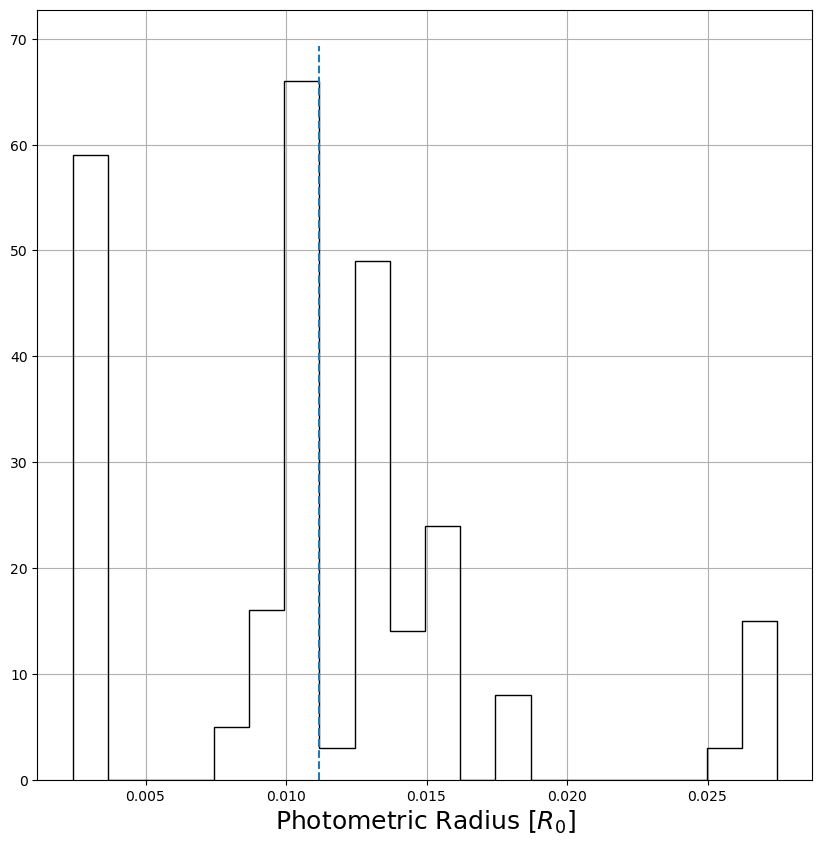

In [18]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(sdss5_catalog['radius'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(sdss5_catalog['radius']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_{0}]$', fontsize=18)
#plt.savefig('plots/photometry/radius.png')

In [38]:
nug5 = sdss5_catalog[['wd_source_id', 'phot_teff', 'e_phot_teff', 'converged', 'reliable_dist']]
nug5.write('data/nug5.fits', overwrite = True)
sdss5_catalog.write('data/sdss5_catalog_photo.fits', overwrite = True)